# Train YOLOv2 on LISA Dataset
-----------------------------------------------


In [1]:
import sys
print(sys.version) # Check Python Version
import os
from keras.optimizers import Adam
from cfg import *

2.7.13 |Anaconda 4.4.0 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


Using TensorFlow backend.


### Prepare LISA Dataset

In [2]:
import numpy as np
from utils.parse_input import load_data    # Data handler for LISA dataset

x_train, y_train = load_data('training.txt')
labels           = np.unique(y_train[:,1])
num_classes      = len(labels)            # Count number of classes in the dataset

print("Train: {} samples\nNumber of classes: {}".format(len(x_train),num_classes))
print("\nLabel Sample: \n{}".format(y_train[0]))


Number of ground truth boxes: 3672 boxes
Train: 3672 samples
Number of classes: 31

Label Sample: 
[1093.5 408.0 45.0 48.0 'doNotEnter']


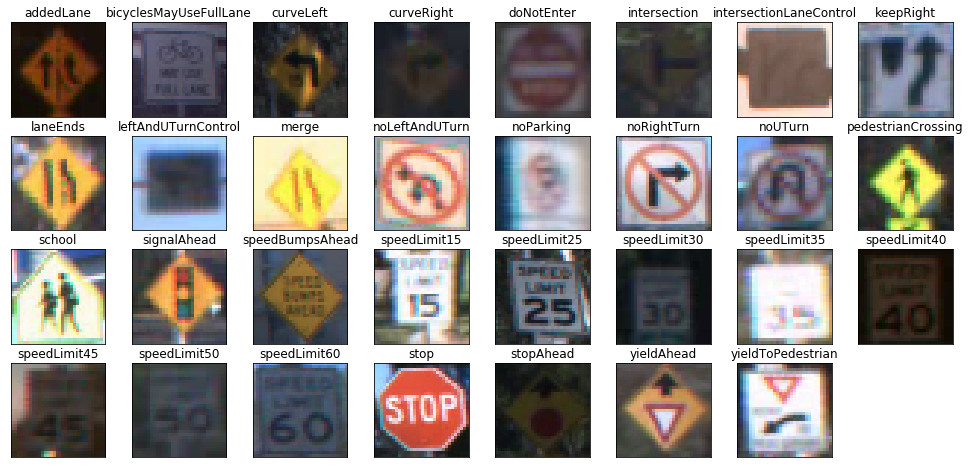

In [3]:
import cv2
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

def extract_sign(img, bbox, output_size=(32, 32)):
    xc, yc, w, h = bbox.x, bbox.y, bbox.w, bbox.h
    x1   = int(xc - w/2)
    y1   = int(yc - h/2)
    x2   = int(xc + w/2)
    y2   = int(yc + h/2)
    roi = cv2.resize(img[y1:y2, x1:x2], output_size)
    return roi

x_train, y_train = shuffle(x_train, y_train)
fig = plt.figure(figsize=(17, 8))
for i, label in enumerate(labels):
    ax           = fig.add_subplot(4, 8, 1 + i, xticks=[], yticks=[])
    idx          = np.where(y_train[:, 1] == label)[0][0]
    img          = cv2.cvtColor(cv2.imread(x_train[idx]), cv2.COLOR_BGR2RGB)
    box          = y_train[idx][0]
    sign_only    = extract_sign(img, box, (32, 32)) #  just extract the sign
    ax.set_title(label)
    plt.imshow(sign_only)
plt.show()

### Construct YOLOv2 On Keras

In [ ]:
from model.yolov2 import YOLOv2, darknet19
import keras.backend as K

K.clear_session() # Avoid duplicate model

darknet19 = darknet19(freeze_layers=True)
yolov2    = YOLOv2(feature_extractor=darknet19, num_anchors=len(ANCHORS), num_classes=N_CLASSES)
model     = yolov2.model
model.load_weights('../yolo-coco.h5', by_name=True)
print(model.summary())

In [ ]:
# from keras.utils import plot_model
# plot_model(model)

## Loss Function

In [ ]:
import keras.backend as K
import tensorflow as tf

def custom_loss(y_true, y_pred):
    """
    y_true: shape [BATCH, NUM_CLASSES + 5]
    y_pred: [BATCH, OUTPUT_W, OUTPUT_H, N_ANCHORS, N_CLASSES + 5]
    
    y_true provides: [xc, yc, w, h, conf, class_prob]
    y
    """
    pred_shape = K.shape(y_pred)[1:3]

    true_boxes, true_conf, true_cls = _process_gt(y_true)
    pred_boxes, pred_conf, pred_cls = _process_prediction(y_pred)
     
    pred_box_scores       = pred_conf * pred_cls
    pred_box_classes      = K.argmax(pred_box_scores, -1)
    pred_box_class_scores = K.max(pred_box_scores, -1)
    
    # Calculate IoU
    iou           = _calc_iou(true_boxes, pred_boxes)
    
    # Create detection mask
    best_box      = tf.equal(iou, tf.reduce_max(iou, [3], True)) 
    best_box      = tf.to_float(best_box)
    true_conf     = tf.expand_dims(best_box * true_conf, -1)   # sigmoid(to) = P(object) * IoU
    pred_conf     = tf.expand_dims(pred_conf, -1)
    
    # Weight Terms
    weight_coor = 5.0 * tf.concat(4 * [true_conf], 4)
    weight_conf = 5.0 * true_conf   + 0.5 * (1. - true_conf)
    weight_prob = 5.0 * tf.concat(N_CLASSES * [true_conf], 4) 
    weight_terms = tf.concat([weight_coor, weight_conf, weight_prob], 4)
    
        
    # Update wh --- > sqrt(wh)
    gt_boxes   = tf.concat([true_boxes[..., :2], tf.sqrt(true_boxes[...,2:4])], 4)
    pred_boxes = tf.concat([pred_boxes[..., :2], tf.sqrt(pred_boxes[...,2:4])], 4)  

    y_true = tf.concat([gt_boxes, true_conf, true_cls], 4)
    y_pred = tf.concat([pred_boxes, pred_conf, pred_cls], 4)
        
    # Total loss
    loss = tf.pow(y_pred - y_true, 2)
    loss = loss * weight_terms
    loss = tf.reshape(loss, [-1,N_ANCHORS*(5+ N_CLASSES)* K.cast(pred_shape[0]*pred_shape[1], tf.int32)])
    loss = tf.reduce_sum(loss, 1)
    loss = .5 * tf.reduce_mean(loss)
    
    return loss

def _process_gt(y_true):
    """
    Process ground truth output
    """
    gt_shape = K.shape(y_true)
    y_true   = K.reshape(y_true, [gt_shape[0], gt_shape[1], gt_shape[2], N_ANCHORS, N_CLASSES + 5])
    true_xy    = y_true[...,0:2]
    true_wh    = tf.log(y_true[..., 2:4])  # Take natural log because w,h is so small -> affecting prediction
    
    true_boxes = tf.concat([true_xy, true_wh], -1)
    true_conf  = y_true[..., 4]
    true_clf   = y_true[...,5:]
    return true_boxes, true_conf, true_clf


def _process_prediction(y_pred):
    output_shape   = K.shape(y_pred)[1:3]
    OUTPUT_H = tf.cast(output_shape[0], tf.int32)
    OUTPUT_W = tf.cast(output_shape[1], tf.int32)
    
    # Scaled anchors to size of feature map
    y_pred         = K.reshape(y_pred, [-1, output_shape[0], output_shape[1], N_ANCHORS, N_CLASSES + 5])

     # Create offset map
    c_xy = _create_offset_map(K.shape(y_pred))
    anchors_tensor = tf.cast(K.reshape(K.variable(ANCHORS), [1, 1, 1, 5, 2]), tf.float32)
    netout_size   = K.cast(K.reshape([OUTPUT_H, OUTPUT_H], [1, 1, 1, 1, 2]), K.dtype(netout))

    box_xy          = K.sigmoid(netout[..., :2])
    box_wh          = K.exp(netout[..., 2:4])
    box_confidence  = K.sigmoid(netout[..., 4:5])
    box_class_probs = K.softmax(netout[..., 5:])

    # Adjust predictions to each spatial grid point and anchor size.
    box_xy = (box_xy + c_xy) / netout_size
    box_wh = box_wh * anchors_tensor / netout_size

    pred_boxes = tf.stack([box_xy, box_wh], -1)
    
    return pred_boxes,  box_confidence, box_class_probs

def get_box(boxes):
    box_xy = boxes[...,0:2]
    box_wh = boxes[...,2:4]
    
    box_mins  = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    # Y1, X1, Y2, X2
    return K.concatenate([box_mins[..., 1:2], box_mins[..., 0:1],  box_maxes[..., 1:2], box_maxes[..., 0:1]])

                           
def _calc_iou(true_boxes, pred_boxes):
    # Scaled anchors to size of feature map
    output_shape   = K.shape(pred_boxes)[1:3]
    
    # Scale to input image
    GRID_SIZE =  K.cast(K.reshape([output_shape[1], output_shape[0]], [1, 1, 1, 1, 2]), tf.float32)
    
    pred_xy     = pred_boxes[...,:2]  * GRID_SIZE
    pred_wh     = pred_boxes[..., 2:4]* GRID_SIZE
    pred_area   = pred_wh[..., 0]     * pred_wh[..., 1]

    true_xy     = true_boxes[...,:2]  * GRID_SIZE
    true_wh     = true_boxes[...,2:4] * GRID_SIZE
    true_area   = true_wh[..., 0]     * true_wh[..., 1]
    
    # Calculate IoU between ground truth and prediction
    intersect_ul   = tf.maximum(pred_xy - 0.5*pred_wh, true_xy - 0.5*true_wh)
    intersect_br   = tf.minimum(pred_xy + 0.5*pred_wh, true_xy + 0.5*true_wh)
    intersect_wh   = tf.maximum(intersect_br - intersect_ul, 0.0)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]

    iou = tf.truediv(intersect_area, true_area + pred_area - intersect_area)
    
    return iou

def _create_offset_map(output_shape):
    """
    In Yolo9000 paper, grid map
    """
    cx = tf.cast((K.arange(0, stop=GRID_W)), dtype=tf.float32)
    cx = K.tile(cx, [GRID_H])
    cx = K.reshape(cx, [-1, GRID_H, GRID_W, 1])

    cy = K.cast((K.arange(0, stop=GRID_H)), dtype=tf.float32)
    cy = K.reshape(cy, [-1, 1])
    cy = K.tile(cy, [1, GRID_W])  
    cy = K.reshape(cy, [-1])    
    cy = K.reshape(cy, [-1, GRID_H, GRID_W, 1])

    c_xy = tf.stack([cx, cy], -1)
    c_xy = K.cast(c_xy, K.dtype(netout))

    return cx, cy

In [ ]:
def avg_iou(y_true, y_pred):
    pred_shape = K.shape(y_pred)[1:3]

    true_boxes, true_conf, true_cls = _process_gt(y_true)
    pred_boxes, pred_conf, pred_cls = _process_prediction(y_pred)
    
    iou           = _calc_iou(true_boxes, pred_boxes)
    true_conf     = tf.expand_dims(iou * true_conf, -1)   # sigmoid(to) = P(object) * IoU
    return tf.reduce_sum(true_conf)

def coor(y_true, y_pred):
    pred_shape = K.shape(y_pred)[1:3]

    true_boxes, true_conf, true_cls = _process_gt(y_true)
    pred_boxes, pred_conf, pred_cls = _process_prediction(y_pred)
    
    iou           = _calc_iou(true_boxes, pred_boxes)
    best_box      = tf.equal(iou, tf.reduce_max(iou, [3], True)) 
    best_box      = tf.to_float(best_box)
    true_conf     = tf.expand_dims(best_box * true_conf, -1)   # sigmoid(to) = P(object) * IoU
    pred_conf     = tf.expand_dims(pred_conf, -1)
    
    # Update wh --- > sqrt(wh)
    gt_boxes   = tf.concat([true_boxes[..., :2], tf.sqrt(true_boxes[...,2:4])], 4)
    pred_boxes = tf.concat([pred_boxes[..., :2], tf.sqrt(pred_boxes[...,2:4])], 4)  

    weight_coor = 5.0 * tf.concat(4 * [true_conf], 4)
    coor_loss = tf.pow(pred_boxes - gt_boxes, 2) * weight_coor
    
    return tf.reduce_sum(coor_loss)

def obj(y_true, y_pred):
    pred_shape = K.shape(y_pred)[1:3]

    true_boxes, true_conf, true_cls = _process_gt(y_true)
    pred_boxes, pred_conf, pred_cls = _process_prediction(y_pred)
    iou           = _calc_iou(true_boxes, pred_boxes)
    
    best_box      = tf.equal(iou, tf.reduce_max(iou, [3], True)) 
    best_box      = tf.to_float(best_box)
    true_conf     = tf.expand_dims(best_box * true_conf, -1)   # sigmoid(to) = P(object) * IoU
    pred_conf     = tf.expand_dims(pred_conf, -1)
    
    weight_conf = 5.0 * true_conf   + 0.5 * (1. - true_conf)
    obj_conf = tf.pow(pred_conf - true_conf, 2) * weight_conf
    
    return tf.reduce_sum(obj_conf)


In [ ]:
import os
import keras
from sklearn.model_selection import train_test_split

from utils.multi_gpu import make_parallel, get_gpus
from utils.data_generator import flow_from_list

# # HYPER-PARAMETERS
BATCH_SIZE = 8
EPOCHS     = 100
LEARN_RATE = 0.00005 # this model has been pre-trained, LOWER LR is needed

# Data Generator
train_data_gen = flow_from_list(x_train, y_train, batch_size=BATCH_SIZE, augment_data=True)

backup_path = '/home/ubuntu/dataset/backup/'
# For Debugging purpose
tf_board   = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.000001, patience=3, mode='min', verbose=1)
save_model = keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch,logs: model.save_weights(backup_path + 'yolov2-epoch%s-loss%s.weights'%(epoch, str(logs.get('loss')))))

In [ ]:
from keras.optimizers import Adam, SGD
# Load pretrain weights
# model.load_weights("yolov2.weights")

# Set up Data parallelism
n_gpus = get_gpus()
if n_gpus > 1:
    BATCH_SIZE = n_gpus * BATCH_SIZE
    model_par = make_parallel(model, n_gpus)
else:
    model_par = model

# Set up optimizer
sgd = SGD(LEARN_RATE, decay=0.0005, momentum=0.9)
# adam = Adam(0.00001)
# Compiling model
model_par.compile(optimizer=sgd,loss=custom_loss, metrics=[avg_iou, coor, obj])

hist =  model_par.fit_generator(generator     = train_data_gen, 
                            steps_per_epoch   = 200, 
                            epochs            = EPOCHS, 
                            callbacks         = [tf_board, early_stop, save_model],
                            workers=1, verbose=1)

model.save_weights('yolov2.weights')

## Multi-GPUs Training - Data Parallelism Approach

* Each GPU will have a copy of the model
* During training time, mean of all gradidents from each GPU will be calculated to update the model
<img style="width:40%" src="https://www.tensorflow.org/images/Parallelism.png">

In [ ]:
model.load_weights('yolov2.weights')

### Visualize training process using Tensorboard
Open `http://<public-dns>:6006`

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# samples, labels = train_data_gen.next()
# i = 2
# img    = samples[i]
# labels = labels.reshape([-1, 30, 40, 5, 36])
# box    = labels[i][8][30][0][:4]*np.array([1280, 960, 1280, 960])
# print(box)

# dot    = cv2.circle(img, (int(box[0]), int(box[1])), radius=5, color=[0, 1, 0], thickness=5)

# plt.figure(figsize=(10, 10))
# plt.imshow(dot)